# 0x11 Generative Adversarial Networks (GANs)

In this notebook we will implement a Generative Adversarial Network (GAN).

GAN is a framework for generative modeling where two neural networks - a Generator and a Discriminator - compete against each other in a minimax game. The Generator learns to create realistic samples, while the Discriminator learns to distinguish real from fake samples.

Although GANs are typically used for high-dimensional data like images, the same methodology could be applied to low-dimensional data as well.
In this example, we will start with a simple 1D Gaussian to illustrate the core concepts.

## 1. The GAN Framework

A GAN consists of two networks:

**Generator (G)**: Takes random noise as input and generates fake samples
- Input: Random noise vector z ~ N(0, 1)
- Output: Fake sample that tries to look real
- Goal: Fool the discriminator into thinking fake samples are real

**Discriminator (D)**: Takes a sample and predicts if it's real or fake
- Input: A sample (either real data or generated)
- Output: Probability that the sample is real (0 = fake, 1 = real)
- Goal: Correctly classify real vs fake samples

The two networks play a minimax game:
$$\min_G \max_D \mathbb{E}_{x \sim p_{data}}[\log D(x)] + \mathbb{E}_{z \sim p_z}[\log(1 - D(G(z)))]$$

where $p_{data}$ is the real data distribution and $p_z$ is the noise distribution.

This is actually a zero-sum game and the target is to reach a [Nash equilibrium](https://en.wikipedia.org/wiki/Nash_equilibrium).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

np.random.seed(42)
torch.manual_seed(42)

## 2. The Target Distribution

We'll start simple: learning to generate samples from a **single Gaussian distribution**.

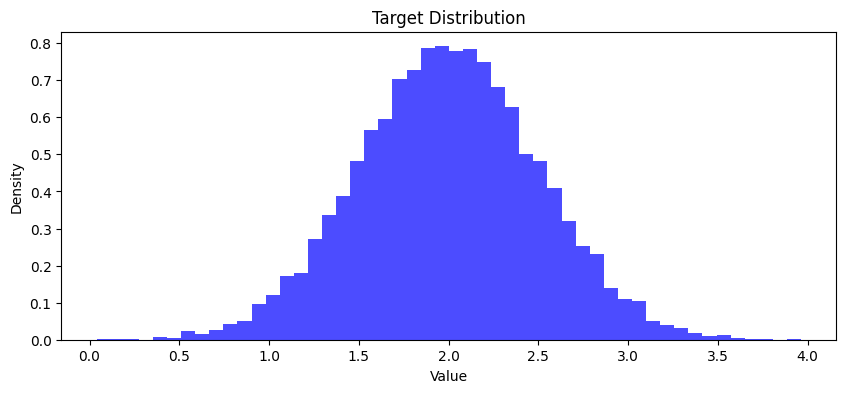

In [2]:
def sample_real_data_single(n, mean, std):
    samples = np.random.normal(mean, std, n)
    return torch.FloatTensor(samples).reshape(-1, 1)

# Visualize the target distribution
real_samples = sample_real_data_single(10000, mean=2, std=0.5).numpy()
plt.figure(figsize=(10, 4))
plt.hist(real_samples, bins=50, alpha=0.7, color='blue', density=True)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Target Distribution')
plt.show()

## 3. Building the Generator and Discriminator

Both networks are just simple MLPs.

In [3]:
class Generator(nn.Module):
    """Generator: noise → 1D sample"""
    def __init__(self, noise_dim=10, hidden_dim=64):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(noise_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, z):
        return self.net(z)

class Discriminator(nn.Module):
    """Discriminator: 1D sample → real/fake probability"""
    def __init__(self, hidden_dim=64):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

# Initialize networks
G = Generator()
D = Discriminator()

print("Generator architecture:")
print(G)
print("\nDiscriminator architecture:")
print(D)

Generator architecture:
Generator(
  (net): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)

Discriminator architecture:
Discriminator(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=64, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


## 4. Training the GAN

The training alternates between:
1. **Train Discriminator**: Maximize ability to distinguish real from fake
2. **Train Generator**: Maximize ability to fool the discriminator

In [4]:
# Hyperparameters
noise_dim = 10
batch_size = 256
num_iterations = 1000
lr = 0.001

# Optimizers
optimizer_G = optim.Adam(G.parameters(), lr=lr)
optimizer_D = optim.Adam(D.parameters(), lr=lr)

# Loss function
criterion = nn.BCELoss()

# Labels for real and fake
real_label = 1.0
fake_label = 0.0

In [5]:
# Training loop
D_losses = []
G_losses = []

for iteration in range(num_iterations):
    # ============================================
    # Train Discriminator
    # ============================================
    optimizer_D.zero_grad()

    # Train with real data
    real_data = sample_real_data_single(batch_size, mean=2, std=0.5)
    real_labels = torch.full((batch_size, 1), real_label)

    output_real = D(real_data)
    loss_D_real = criterion(output_real, real_labels)

    # Train with fake data
    noise = torch.randn(batch_size, noise_dim)
    fake_data = G(noise)
    fake_labels = torch.full((batch_size, 1), fake_label)

    output_fake = D(fake_data.detach())  # detach to avoid backprop through G
    loss_D_fake = criterion(output_fake, fake_labels)

    # Total discriminator loss
    loss_D = loss_D_real + loss_D_fake
    loss_D.backward()
    optimizer_D.step()

    # ============================================
    # Train Generator
    # ============================================
    optimizer_G.zero_grad()

    # Generate fake data
    noise = torch.randn(batch_size, noise_dim)
    fake_data = G(noise)

    # Try to fool discriminator (label fake as real)
    output = D(fake_data)
    loss_G = criterion(output, real_labels)  # Want D to output 1 for fake data

    loss_G.backward()
    optimizer_G.step()

    # Record losses
    D_losses.append(loss_D.item())
    G_losses.append(loss_G.item())

    # Print progress
    if iteration % 100 == 0:
        print(f"Iteration {iteration}/{num_iterations} | D Loss: {loss_D.item():.4f} | G Loss: {loss_G.item():.4f}")

print("\nTraining complete!")

Iteration 0/1000 | D Loss: 1.5242 | G Loss: 0.7962
Iteration 100/1000 | D Loss: 1.6152 | G Loss: 0.4794
Iteration 200/1000 | D Loss: 1.3286 | G Loss: 0.9740
Iteration 300/1000 | D Loss: 1.4060 | G Loss: 0.7851
Iteration 400/1000 | D Loss: 1.3889 | G Loss: 0.6808
Iteration 500/1000 | D Loss: 1.3885 | G Loss: 0.6778
Iteration 600/1000 | D Loss: 1.3869 | G Loss: 0.6873
Iteration 700/1000 | D Loss: 1.3857 | G Loss: 0.7105
Iteration 800/1000 | D Loss: 1.3805 | G Loss: 0.7290
Iteration 900/1000 | D Loss: 1.3615 | G Loss: 0.8296

Training complete!


## 5. Visualizing the Results

Let's see how well the generator learned to match the real distribution.

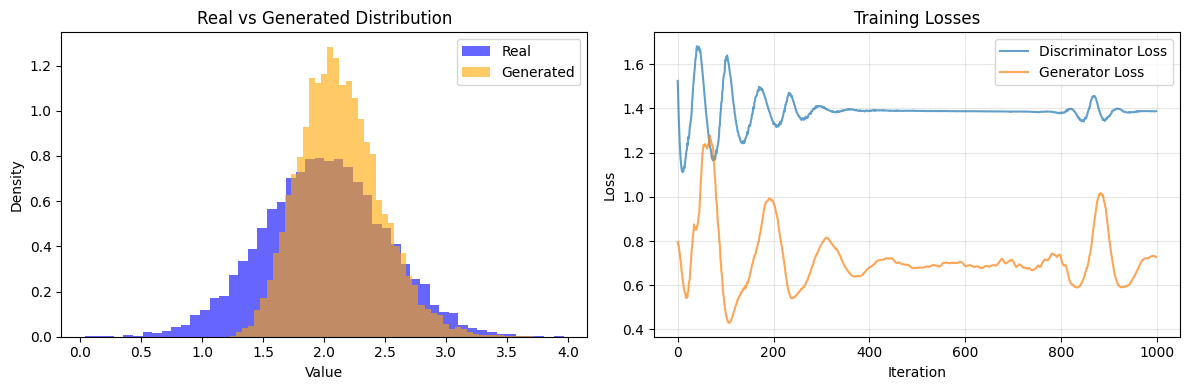

In [6]:
# Generate samples from trained generator
with torch.no_grad():
    noise = torch.randn(10000, noise_dim)
    generated_samples = G(noise).numpy()

# Plot real vs generated
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(real_samples, bins=50, alpha=0.6, color='blue', density=True, label='Real')
plt.hist(generated_samples, bins=50, alpha=0.6, color='orange', density=True, label='Generated')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Real vs Generated Distribution')
plt.legend()

# Plot loss curves
plt.subplot(1, 2, 2)
plt.plot(D_losses, label='Discriminator Loss', alpha=0.7)
plt.plot(G_losses, label='Generator Loss', alpha=0.7)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

> 🤔 **THINKING**
>
> - Why do the losses oscillate rather than converge to a stable value?

## 6. Visualizing Training Dynamics

Let's see how the generator evolves during training by visualizing snapshots at different iterations.

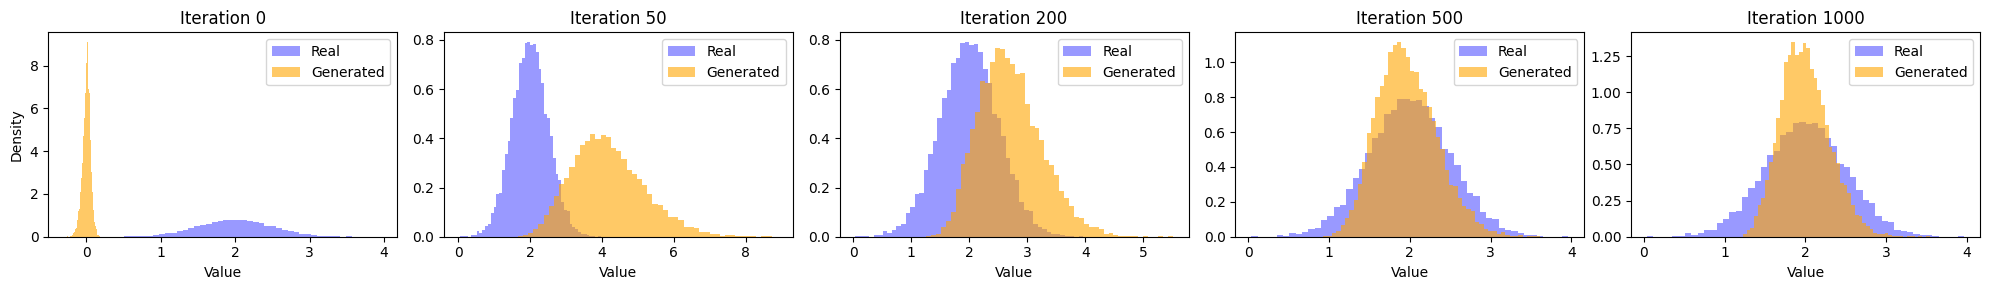

In [7]:
# Train a new GAN and save snapshots
G_new = Generator()
D_new = Discriminator()
optimizer_G_new = optim.Adam(G_new.parameters(), lr=lr)
optimizer_D_new = optim.Adam(D_new.parameters(), lr=lr)

snapshots = {}  # Store generator states
snapshot_iterations = [0, 50, 200, 500, 1000]

for iteration in range(1001):
    # Train Discriminator
    optimizer_D_new.zero_grad()
    real_data = sample_real_data_single(batch_size, mean=2, std=0.5)
    real_labels = torch.full((batch_size, 1), real_label)
    noise = torch.randn(batch_size, noise_dim)
    fake_data = G_new(noise)
    fake_labels = torch.full((batch_size, 1), fake_label)

    loss_D = criterion(D_new(real_data), real_labels) + criterion(D_new(fake_data.detach()), fake_labels)
    loss_D.backward()
    optimizer_D_new.step()

    # Train Generator
    optimizer_G_new.zero_grad()
    noise = torch.randn(batch_size, noise_dim)
    fake_data = G_new(noise)
    loss_G = criterion(D_new(fake_data), real_labels)
    loss_G.backward()
    optimizer_G_new.step()

    # Save snapshots
    if iteration in snapshot_iterations:
        with torch.no_grad():
            noise = torch.randn(10000, noise_dim)
            snapshots[iteration] = G_new(noise).numpy()

# Plot evolution
fig, axes = plt.subplots(1, len(snapshot_iterations), figsize=(20, 3))
for idx, iteration in enumerate(snapshot_iterations):
    axes[idx].hist(real_samples, bins=50, alpha=0.4, color='blue', density=True, label='Real')
    axes[idx].hist(snapshots[iteration], bins=50, alpha=0.6, color='orange', density=True, label='Generated')
    axes[idx].set_title(f'Iteration {iteration}')
    axes[idx].set_xlabel('Value')
    if idx == 0:
        axes[idx].set_ylabel('Density')
    axes[idx].legend()

plt.tight_layout()
plt.show()

## 7. Interactive session: Mixture of Two Gaussians

One Gaussian maybe too simple, so now let's try learning to generate from a **mixture of 2 Gaussians**.

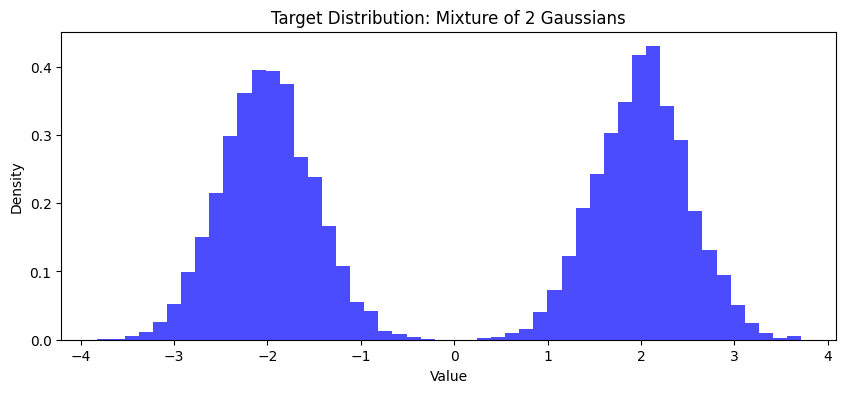

In [8]:
# Define two-Gaussian mixture
def sample_real_data_mixture(n):
    """Sample from a mixture of 2 Gaussians."""
    # 50% from N(-2, 0.5), 50% from N(2, 0.5)
    cluster = np.random.choice([0, 1], n)
    samples = np.where(cluster == 0,
                      np.random.normal(-2, 0.5, n),
                      np.random.normal(2, 0.5, n))
    return torch.FloatTensor(samples).reshape(-1, 1)

# Visualize the two-mode distribution
real_samples_mixture = sample_real_data_mixture(10000).numpy()
plt.figure(figsize=(10, 4))
plt.hist(real_samples_mixture, bins=50, alpha=0.7, color='blue', density=True)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Target Distribution: Mixture of 2 Gaussians')
plt.show()

> **📚 EXERCISE**
>
> - Using the same GAN architecture, implement training on a mixture of two Gaussians.
> - Implement same visualization as before to see how well the generator learns.

In [9]:
G_mixture = Generator()
D_mixture = Discriminator()

# === Your code here ===

> **🤔 THINKING**
>
> - What problem did you discover when training on the mixture of Gaussians? (Did the model learn both modes?)
> - If not, can you explain why? Search what this problem is called in GAN.
> - How might you address this problem in practice?